In [1]:
import healpy as hp
import numpy as np
import h5py

def compress_healpix(input_file, output_h5, target_nside=None, dtype=np.uint16):
    # Read the HEALPix map
    map_data = hp.read_map(input_file)
    original_nside = hp.get_nside(map_data)
    print(f"File NSIDE is {original_nside}")
    # Downsample if target_nside is provided
    if target_nside is not None:
        if target_nside >= original_nside:
            raise ValueError("target_nside must be smaller than original NSIDE")
        map_data = hp.ud_grade(map_data, target_nside)
        current_nside = target_nside
    else:
        current_nside = original_nside
    
    # Quantize data to specified dtype (default uint16)
    if dtype != np.float32:
        map_min = np.min(map_data)
        map_max = np.max(map_data)
        scaled_data = (map_data - map_min) / (map_max - map_min)
        
        if dtype == np.uint16:
            quantized = (scaled_data * 65535).astype(dtype)
        elif dtype == np.uint8:
            quantized = (scaled_data * 255).astype(dtype)
        else:
            raise ValueError("Unsupported dtype. Use uint8/uint16/float32")
    else:
        quantized = map_data.astype(np.float32)
        map_min = map_max = None  # No scaling needed
    
    # Save to HDF5 with compression and metadata
    with h5py.File(output_h5, 'w') as f:
        dset = f.create_dataset('map', data=quantized, compression='gzip', compression_opts=9)
        dset.attrs['original_nside'] = original_nside
        dset.attrs['current_nside'] = current_nside
        if dtype != np.float32:
            dset.attrs['min_val'] = map_min
            dset.attrs['max_val'] = map_max
        dset.attrs['dtype'] = str(quantized.dtype)

In [2]:
def decompress_healpix(input_h5):
    """Decompress a HEALPix map from an HDF5 file."""
    with h5py.File(input_h5, 'r') as f:
        dset = f['map']
        quantized = dset[:]
        metadata = {
            'original_nside': dset.attrs['original_nside'],
            'current_nside': dset.attrs['current_nside'],
            'dtype': dset.attrs['dtype']
        }
        if metadata['dtype'] != 'float32':
            metadata['min_val'] = dset.attrs['min_val']
            metadata['max_val'] = dset.attrs['max_val']
    
    if metadata['dtype'] == 'uint16':
        scaled = quantized.astype(np.float32) / 65535
    elif metadata['dtype'] == 'uint8':
        scaled = quantized.astype(np.float32) / 255
    else:
        return quantized, metadata
    
    reconstructed = scaled * (metadata['max_val'] - metadata['min_val']) + metadata['min_val']
    reconstructed[quantized == 0] = np.nan  # Preserve NaN values
    return reconstructed, metadata

In [5]:
import matplotlib.pyplot as plt

def visualize_maps(original_map, compressed_map, original_nside, compressed_nside, dtype):
    """Visualize original and compressed HEALPix maps side-by-side."""
    plt.figure(figsize=(16, 20))
    
    # Plot original map
    hp.mollview(original_map, 
                sub=(2, 1, 1),
                title=f"Original Map\nNSIDE={original_nside}",
                unit='Temperature [μK]',
                min=np.nanmin(original_map),
                max=np.nanmax(original_map))
    
    # Plot compressed map
    hp.mollview(compressed_map, 
                sub=(2, 1, 2),
                title=f"Compressed Map\nNSIDE={compressed_nside} ({dtype})",
                unit='Temperature [μK]',
                min=np.nanmin(original_map),
                max=np.nanmax(original_map))
    
    plt.tight_layout()
    hp.graticule()
    plt.show()

/tmp/ipykernel_84097/2172742226.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


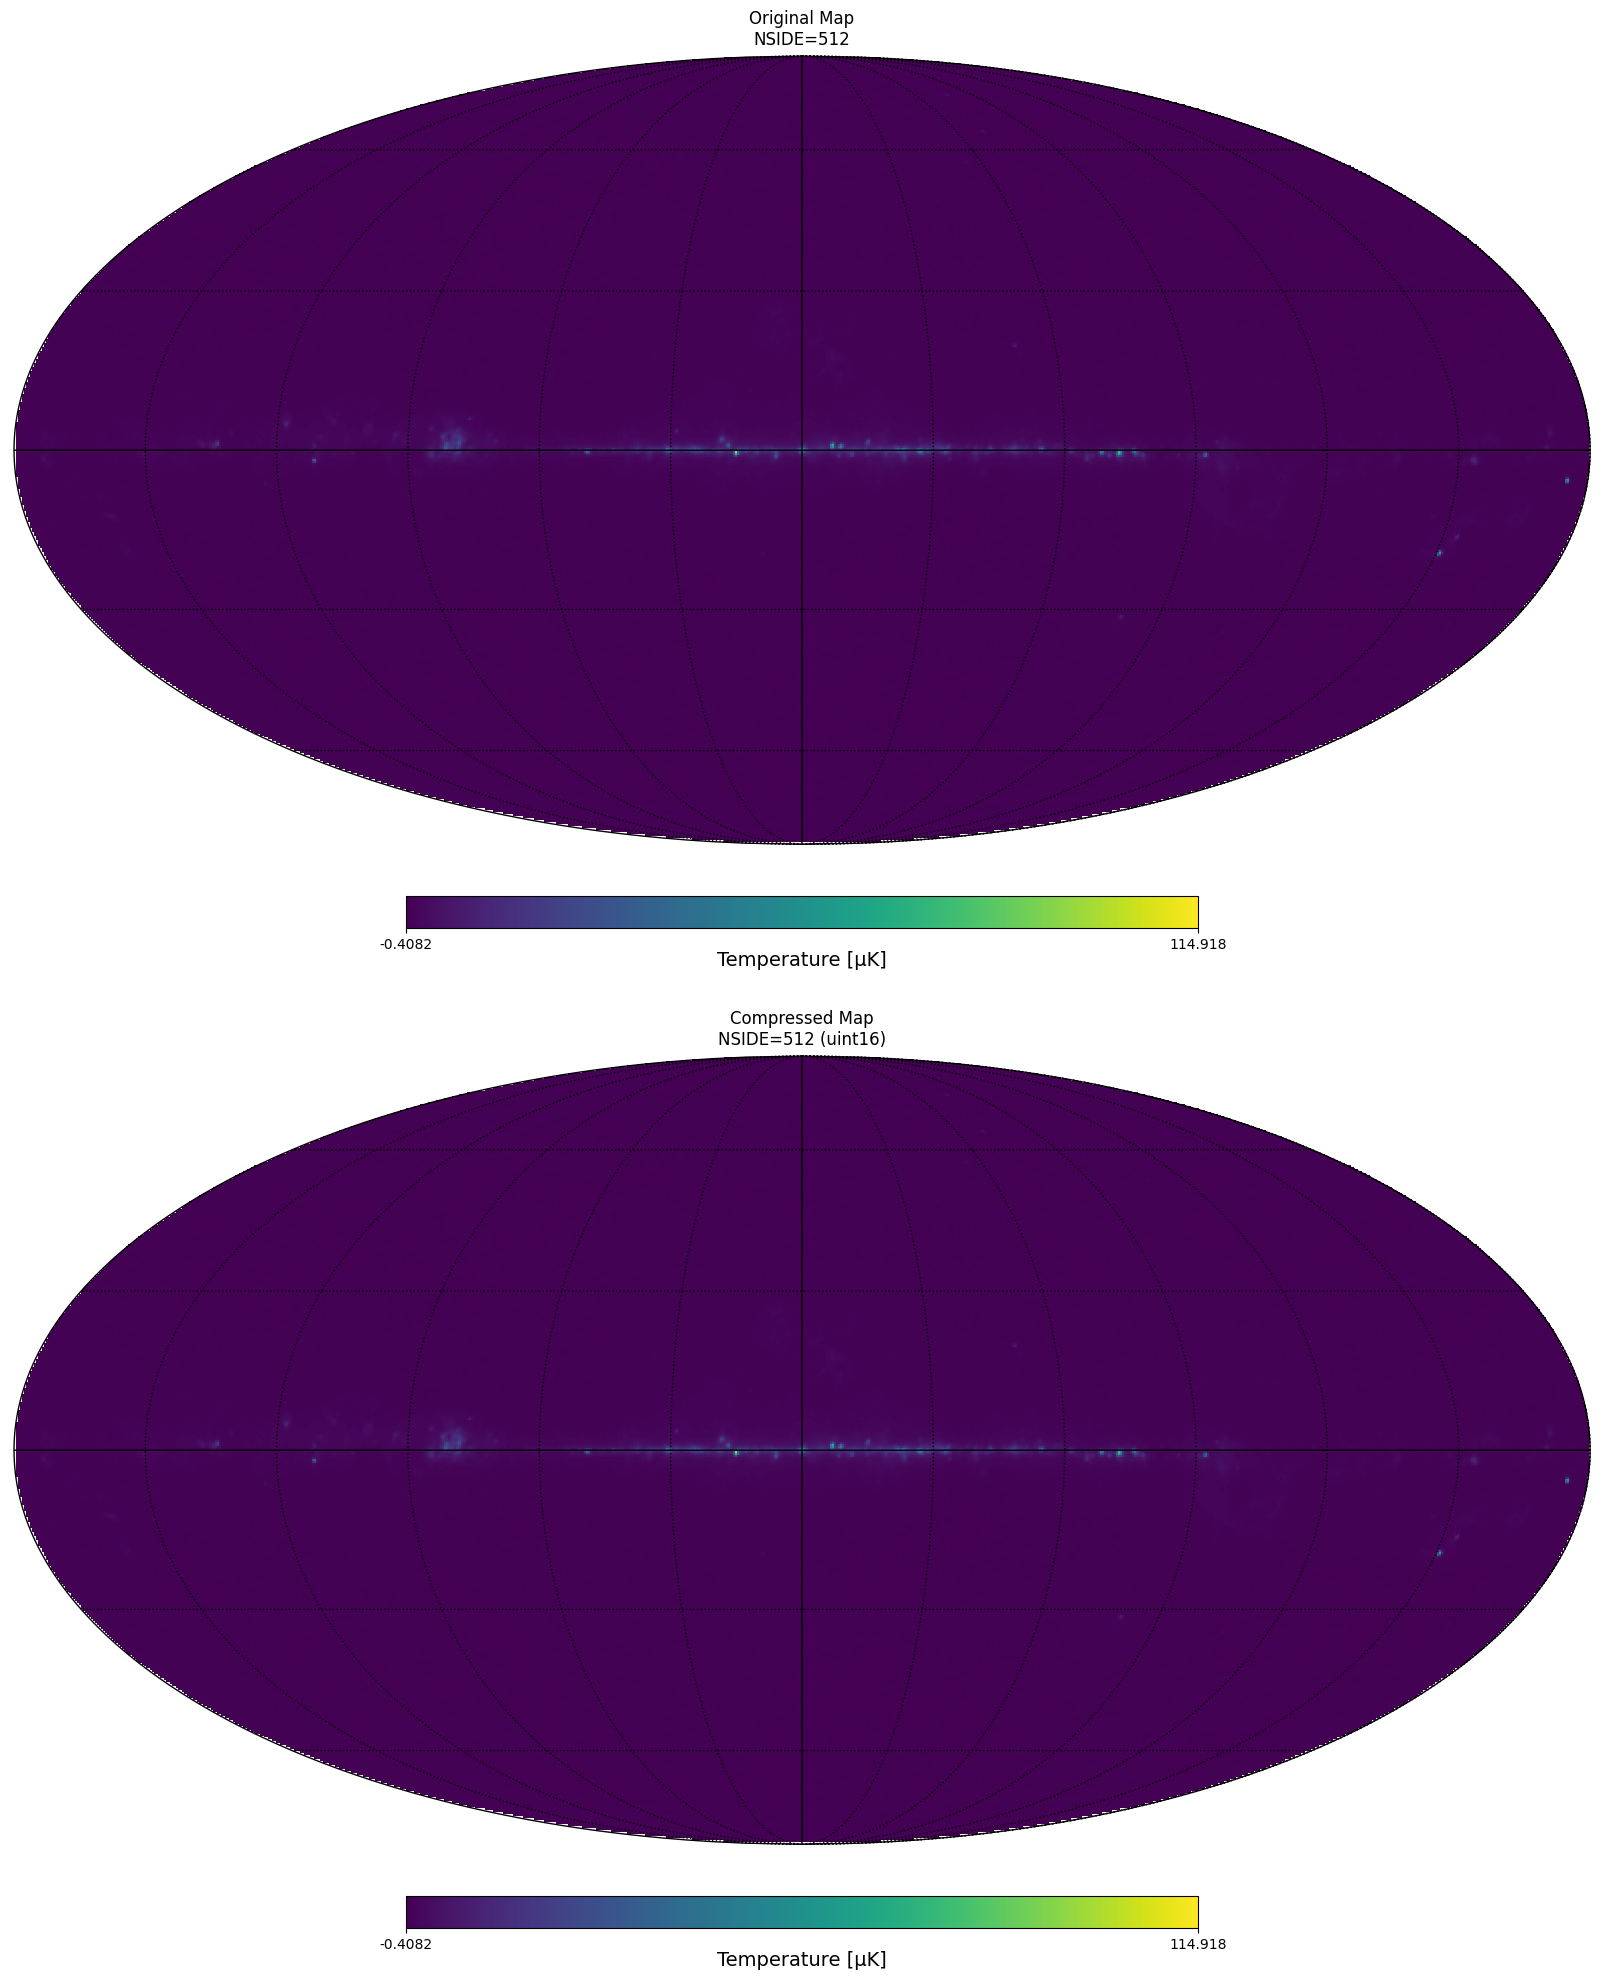

In [6]:
# Example usage
if __name__ == "__main__":
    input_fits = "wmap_band_iqumap_r9_7yr_Ka_v4.fits"  # Replace with your input file
    output_h5 = "compressed_map.h5"
    
    # Compress the map
    # compress_healpix(input_fits, output_h5, target_nside=1024, dtype=np.uint16)
    
    # Load original and compressed maps
    original_map = hp.read_map(input_fits)
    compressed_map, meta = decompress_healpix(output_h5)
    
    # Visualize the maps
    visualize_maps(original_map, compressed_map, 
                   original_nside=hp.get_nside(original_map), 
                   compressed_nside=meta['current_nside'], 
                   dtype=meta['dtype'])

File NSIDE is 512


/tmp/ipykernel_84097/2172742226.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


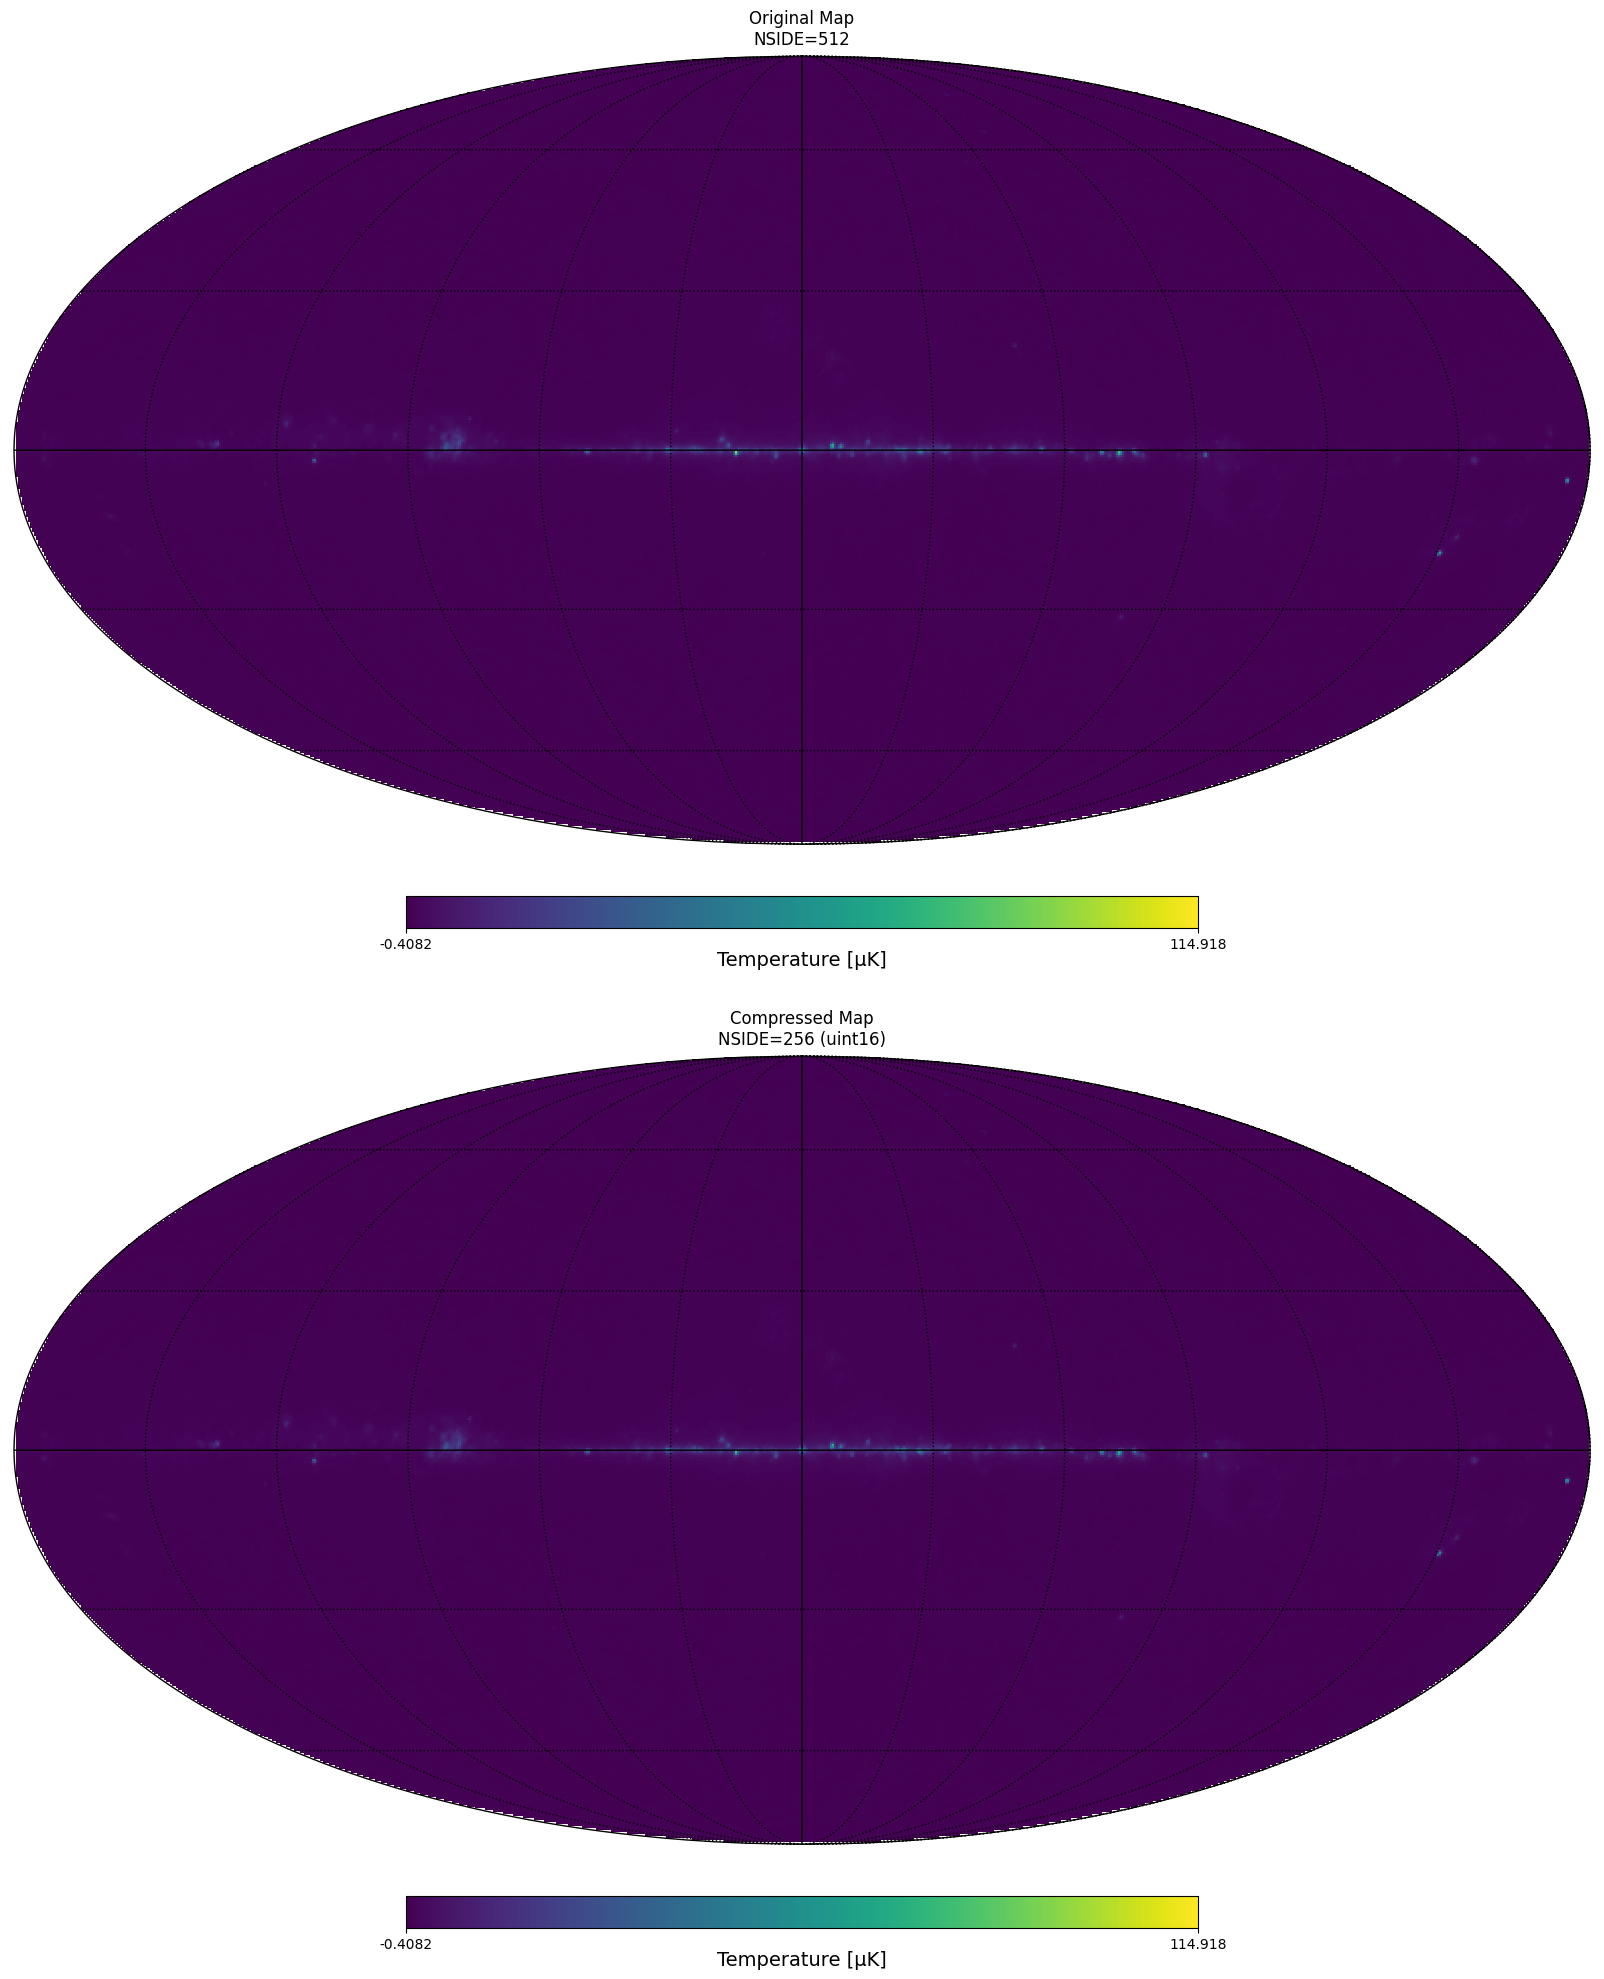

In [7]:
if __name__ == "__main__":
    input_fits = "wmap_band_iqumap_r9_7yr_Ka_v4.fits"  # Replace with your input file
    output_h5 = "compressed_map_NSIDE-256.h5"
    
    # Compress the map
    compress_healpix(input_fits, output_h5, target_nside=256, dtype=np.uint16)
    
    # Load original and compressed maps
    original_map = hp.read_map(input_fits)
    compressed_map, meta = decompress_healpix(output_h5)
    
    # Visualize the maps
    visualize_maps(original_map, compressed_map, 
                   original_nside=hp.get_nside(original_map), 
                   compressed_nside=meta['current_nside'], 
                   dtype=meta['dtype'])